In [1]:
import pandas as pd
for enc in ['latin1', 'ISO-8859-1', 'cp1252']:
    try:
        df = pd.read_csv('IFND.csv', encoding=enc)
        print(f"Successfully read with encoding {enc}")
        print(df.head())
        print("Shape:", df.shape)
        print("Columns:", df.columns.tolist())
        print("Missing values per column:\n", df.isnull().sum())
        break
    except Exception as e:
        print(f"Failed with {enc}: {e}")


Successfully read with encoding latin1
                                           Statement  Label
0  WHO praises India's Aarogya Setu app, says it ...      1
1  In Delhi, Deputy US Secretary of State Stephen...      1
2  LAC tensions: China's strategy behind delibera...      1
3  India has signed 250 documents on Space cooper...      1
4  Tamil Nadu chief minister's mother passes away...      1
Shape: (4261, 2)
Columns: ['Statement', 'Label']
Missing values per column:
 Statement    0
Label        0
dtype: int64


In [2]:
!pip install dataset

Defaulting to user installation because normal site-packages is not writeable

You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
df['Statement'] = df['Statement'].astype(str).str.strip()

In [4]:
import re
def clean_text(text):
    text = re.sub(r'[%‰Ûª]+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return text.strip()

df['Statement'] = df['Statement'].astype(str).apply(clean_text)

In [5]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [6]:
from transformers import AutoTokenizer
import pandas as pd
from datasets import Dataset, DatasetDict
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_df = pd.read_csv('IFND.csv', encoding='latin1')
test_df = pd.DataFrame()

def tokenize_function(examples):
    return tokenizer(examples['Statement'], truncation=True, padding='max_length', max_length=128)


In [7]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('IFND.csv', encoding='latin1')
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

train_df = train_df.rename(columns={'Label': 'labels'})
test_df = test_df.rename(columns={'Label': 'labels'})
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3408 [00:00<?, ? examples/s]

Map:   0%|          | 0/853 [00:00<?, ? examples/s]

In [8]:
# 3. Model and TrainingArguments
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",  # Correct parameter name
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)






import os

# where Trainer will save checkpoints
output_dir = training_args.output_dir  

# look for any saved checkpoints
if os.path.isdir(output_dir) and any(
    name.startswith("checkpoint-") for name in os.listdir(output_dir)
):
    print(f"Found existing checkpoint in {output_dir}, resuming training…")
    # resume from the latest checkpoint
    checkpoints = sorted(
        d for d in os.listdir(output_dir) if d.startswith("checkpoint-")
    )
    latest_checkpoint = os.path.join(output_dir, checkpoints[-1])
    trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("No checkpoint found, starting fresh training…")
    trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ayush\AppData\Local\Temp\ipykernel_7100\2281723726.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


No checkpoint found, starting fresh training…


Epoch,Training Loss,Validation Loss
1,0.345800,0.178453
2,0.062800,0.215032
3,0.001200,0.166780


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       430
           1       0.96      0.96      0.96       423

    accuracy                           0.96       853
   macro avg       0.96      0.96      0.96       853
weighted avg       0.96      0.96      0.96       853



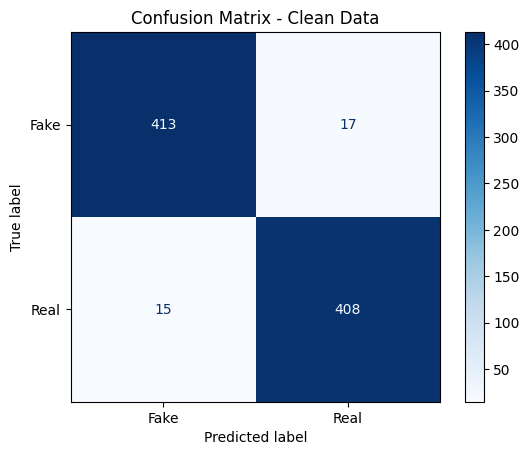

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = trainer.predict(test_dataset)
y_true = y_true = test_df['labels'].values
y_pred = preds.predictions.argmax(axis=1)
print(classification_report(y_true, y_pred))

cm_clean = confusion_matrix(y_true, y_pred)
disp_clean = ConfusionMatrixDisplay(confusion_matrix=cm_clean, display_labels=['Fake', 'Real'])
disp_clean.plot(cmap='Blues')
plt.title("Confusion Matrix - Clean Data")
plt.savefig("confusion_matrix_clean.png")
plt.show()

In [10]:
!pip install textattack

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [11]:
from textattack.models.wrappers import HuggingFaceModelWrapper

In [12]:
model_wrapper = HuggingFaceModelWrapper(model, tokenizer)

In [13]:
test_df = test_dataset.to_pandas()
print(test_df.columns)

Index(['Statement', 'labels', '__index_level_0__', 'input_ids',
       'token_type_ids', 'attention_mask'],
      dtype='object')


In [14]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [15]:
import os
from textattack import Attacker, AttackArgs
from textattack.attack_recipes import TextFoolerJin2019
from textattack.datasets import Dataset as TA_Dataset

log_path = "attack_log.csv"

if os.path.isfile(log_path):
    print(f"Found existing log at {log_path}, skipping attack.")
    # Optionally, you can load the CSV here for downstream analysis:
    # import pandas as pd
    # df_attacks = pd.read_csv(log_path)
else:
    # 1) Prepare your sample dataset
    sample = list(zip(
        test_df['Statement'].tolist()[:20],
        test_df['labels'].tolist()[:20],
    ))
    ta_dataset = TA_Dataset(sample)

    # 2) Build the attack
    attack = TextFoolerJin2019.build(model_wrapper)

    # 3) Configure how you want attacks to run
    attack_args = AttackArgs(
        num_examples=20,          # how many samples to attack
        log_to_csv=log_path,
        disable_stdout=True       # suppress per-attack prints
    )

    # 4) Create the Attacker
    attacker = Attacker(attack, ta_dataset, attack_args)

    # 5) Run the attacks
    results = attacker.attack_dataset()

    # 6) Inspect
    for result in results:
        print(result)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path attack_log.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

From C:\Users\ayush\AppData\Roaming\Python\Python39\site-packages\tensorflow_hub\resolver.py:120: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



From C:\Users\ayush\AppData\Roaming\Python\Python39\site-packages\tensorflow_hub\module_v2.py:126: The name tf.saved_model.load_v2 is deprecated. Please use tf.compat.v2.saved_model.load instead.

[Succeeded / Failed / Skipped / Total] 15 / 4 / 1 / 20: 100%|██████████████████████████| 20/20 [25:33<00:00, 76.68s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 15     |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 95.0%  |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 78.95% |
| Average perturbed word %:     | 34.04% |
| Average num. words per input: | 13.45  |
| Avg num queries:              | 151.84 |
+-------------------------------+--------+
1 (100%) --> [FAILED]

YSRCP MP calls party govt in Andhra 'anti-Hindu', faces disqualification
0 (100%) --> 1 (86%)

Gory Video Of A Teenager Hacked To Death In Brazil Passed Off As India

Gori Taping Of A Teenager Hacked To Death In Brazil Passed Off Since India
0 (100%) --> 1 (69%)

Fact Check: Shanghai police drill video goes viral as shooting of three Uyghur Muslims

Accompli Check: Shanghai constables drill cameraman subsides vira

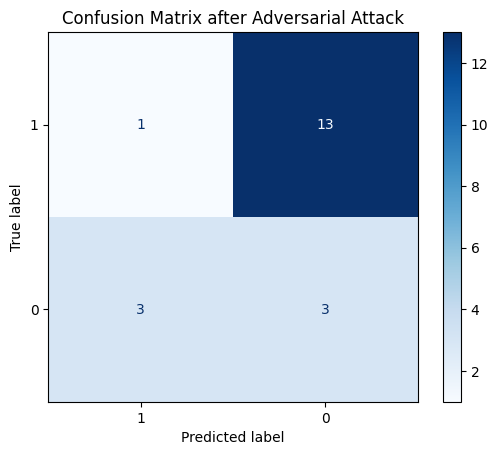

In [16]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Load your TextAttack log
df = pd.read_csv("attack_log.csv")

# 2) Extract ground-truth and adversarial predictions
#   – adjust these column names if yours differ
y_true     = df["ground_truth_output"].values
y_adv_pred = df["perturbed_output"].values #predicted_output

# 3) Compute & display the confusion matrix
cm_adv = confusion_matrix(y_true, y_adv_pred)
disp_adv = ConfusionMatrixDisplay(confusion_matrix=cm_adv,
                                  display_labels=df["ground_truth_output"].unique())
disp_adv.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix after Adversarial Attack")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score
# Load the attack log
df = pd.read_csv("attack_log.csv")

# Extract true and adversarial predicted labels
y_true = df["ground_truth_output"].values
y_pred = df["original_output"].values
y_adv_pred = df["perturbed_output"].values


# Accuracy metrics
acc_clean = accuracy_score(y_true, y_pred)
acc_adv = accuracy_score(y_true, y_adv_pred)
print(f"Accuracy before attack: {acc_clean:.2f}")
print(f"Accuracy after attack: {acc_adv:.2f}")
print(f"Accuracy drop: {acc_clean - acc_adv:.2f}")


Accuracy before attack: 0.95
Accuracy after attack: 0.20
Accuracy drop: 0.75


In [18]:
import numpy as np
attack_successes = np.sum(y_pred != y_adv_pred)
attack_rate = attack_successes / len(y_true)
print(f"Attack Success Rate: {attack_rate:.2f}")


Attack Success Rate: 0.75


In [19]:
import pandas as pd

# Load the attack log
df = pd.read_csv("attack_log.csv")

# Extract relevant columns
original_texts = df["original_text"].tolist()
adversarial_texts = df["perturbed_text"].tolist()
y_pred = df["original_output"].tolist()
y_adv_pred = df["perturbed_output"].tolist()

# Display comparisons
for i, (orig, adv) in enumerate(zip(original_texts, adversarial_texts)):
    print(f"Original: {orig}")
    print(f"Adversarial: {adv}")
    print(f"Original prediction: {y_pred[i]}, Adversarial prediction: {y_adv_pred[i]}")
    print("-" * 50)


Original: YSRCP [[MP]] [[calls]] [[party]] [[govt]] in Andhra 'anti-Hindu', [[faces]] disqualification
Adversarial: YSRCP [[DEPUTY]] [[invitations]] [[servings]] [[bureaucrat]] in Andhra 'anti-Hindu', [[fought]] disqualification
Original prediction: 1, Adversarial prediction: 1
--------------------------------------------------
Original: [[Gory]] [[Video]] Of A Teenager Hacked To Death In Brazil Passed Off [[As]] India
Adversarial: [[Gori]] [[Taping]] Of A Teenager Hacked To Death In Brazil Passed Off [[Since]] India
Original prediction: 0, Adversarial prediction: 1
--------------------------------------------------
Original: [[Fact]] Check: Shanghai [[police]] drill [[video]] [[goes]] viral as [[shooting]] of three Uyghur [[Muslims]]
Adversarial: [[Accompli]] Check: Shanghai [[constables]] drill [[cameraman]] [[subsides]] viral as [[murdered]] of three Uyghur [[Koran]]
Original prediction: 0, Adversarial prediction: 1
--------------------------------------------------
Original: India,

In [20]:
import pandas as pd
from transformers import pipeline

# Load the zero-shot classification pipeline
zero_shot_classifier = pipeline("zero-shot-classification", model=model_name)

# Define the candidate labels
candidate_labels = ["real", "fake"]

# Run classification and store results
results = []
for i, statement in enumerate(test_df['Statement'].tolist()[:10]):
    result = zero_shot_classifier(statement, candidate_labels)
    top_label = result['labels'][0]
    top_score = result['scores'][0]
    results.append({
        "Statement": statement,
        "Predicted Label": top_label,
        "Confidence Score": top_score,
        "All Scores": result['scores'],
        "All Labels": result['labels']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv("zero_shot_results.csv", index=False)

print("Saved results to zero_shot_results.csv")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


Saved results to zero_shot_results.csv


In [21]:
import pandas as pd

# 1) Get predictions and true labels from your Trainer
preds   = trainer.predict(test_dataset)
y_true  = preds.label_ids                    # <— grab true labels
y_pred  = preds.predictions.argmax(axis=1)

# 2) Grab your text inputs from the dataset
statements = test_dataset["Statement"]       # or whatever your text field is called

# 3) Build comparison DataFrame
df_compare = pd.DataFrame({
    "Statement":     statements,
    "Actual (y)":    y_true,
    "Predicted (ŷ)": y_pred
})

# 4) Compute totals
total_samples    = len(df_compare)
correct_count    = (df_compare["Actual (y)"] == df_compare["Predicted (ŷ)"]).sum()
accuracy         = correct_count / total_samples

print(f"Total samples:           {total_samples}")
print(f"Correctly classified:    {correct_count}")
print(f"Incorrectly classified:  {total_samples - correct_count}")
print(f"Accuracy:                {accuracy:.4f}")


Total samples:           853
Correctly classified:    821
Incorrectly classified:  32
Accuracy:                0.9625


In [22]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Step 1: Take a small few-shot labeled dataset
few_shot_df = train_df.sample(n=100, random_state=42)
eval_df = test_df.copy()

# Step 2: Convert to Hugging Face Dataset
few_shot_dataset = Dataset.from_pandas(few_shot_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Step 3: Tokenization
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['Statement'], padding=True, truncation=True)

few_shot_dataset = few_shot_dataset.map(tokenize, batched=True)
eval_dataset = eval_dataset.map(tokenize, batched=True)

# Step 4: Load model and train
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./fewshot-results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="./fewshot-logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=few_shot_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

trainer.train()


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/853 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ayush\AppData\Local\Temp\ipykernel_7100\1578863157.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.444570
2,No log,0.337137
3,No log,0.322717


TrainOutput(global_step=39, training_loss=0.35680487217047274, metrics={'train_runtime': 261.1368, 'train_samples_per_second': 1.149, 'train_steps_per_second': 0.149, 'total_flos': 4779165654000.0, 'train_loss': 0.35680487217047274, 'epoch': 3.0})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ayush\AppData\Local\Temp\ipykernel_7100\3099993213.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.409846
2,No log,0.261585
3,No log,0.272703


Classification Report:
              precision    recall  f1-score     support
Fake           0.970350  0.837209  0.898876  430.000000
Real           0.854772  0.973995  0.910497  423.000000
accuracy       0.905041  0.905041  0.905041    0.905041
macro avg      0.912561  0.905602  0.904687  853.000000
weighted avg   0.913035  0.905041  0.904639  853.000000


<Figure size 800x600 with 0 Axes>

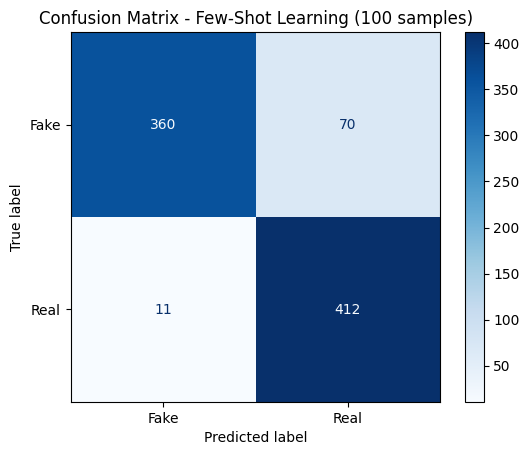

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./fewshot-results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",  # Corrected from eval_strategy
    save_strategy="no",
    logging_dir="./fewshot-logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=few_shot_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Evaluate and visualize results
preds = trainer.predict(eval_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# 1. Classification Report
report = classification_report(y_true, y_pred, output_dict=True, 
                              target_names=['Fake', 'Real'])
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

# 2. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Few-Shot Learning (100 samples)')
plt.savefig('confusion_matrix_fewshot.png')
plt.show()

# 3. Precision-Recall Curve
precision = report_df.loc['Fake', 'precision']
recall = report_df.loc['Fake', 'recall']
f1 = report_df.loc['Fake', 'f1-score']
accuracy = accuracy_score(y_true, y_pred)


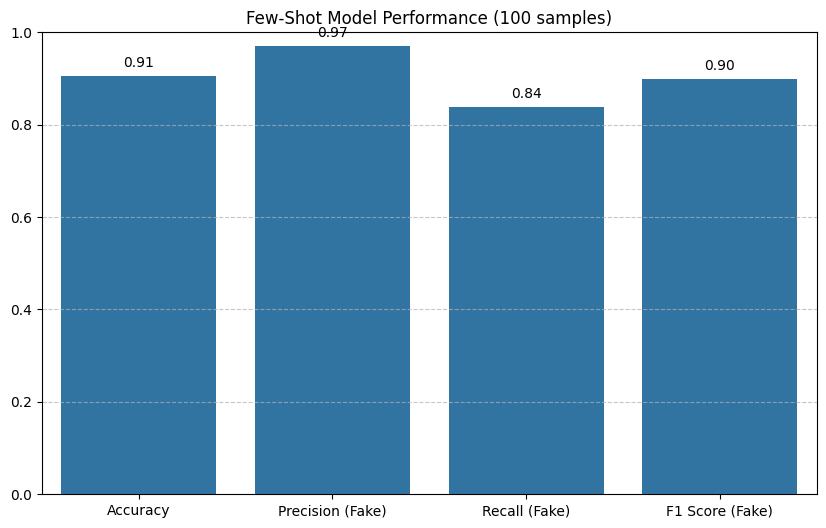


Summary of Few-Shot Learning Results (100 samples):
Accuracy: 0.91
Precision (Fake): 0.97
Recall (Fake): 0.84
F1 Score (Fake): 0.90


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 4. Performance Metrics Visualization
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision (Fake)', 'Recall (Fake)', 'F1 Score (Fake)']
values = [accuracy, precision, recall, f1]
sns.barplot(x=metrics, y=values)
plt.ylim(0, 1.0)
plt.title('Few-Shot Model Performance (100 samples)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.savefig('performance_metrics_fewshot.png')
plt.show()

# 5. Export results to CSV
results_df = pd.DataFrame({
    'Metric': metrics,
    'Value': values
})
results_df.to_csv('fewshot_results.csv', index=False)

# Print summary
print(f"\nSummary of Few-Shot Learning Results (100 samples):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Fake): {precision:.2f}")
print(f"Recall (Fake): {recall:.2f}")
print(f"F1 Score (Fake): {f1:.2f}")

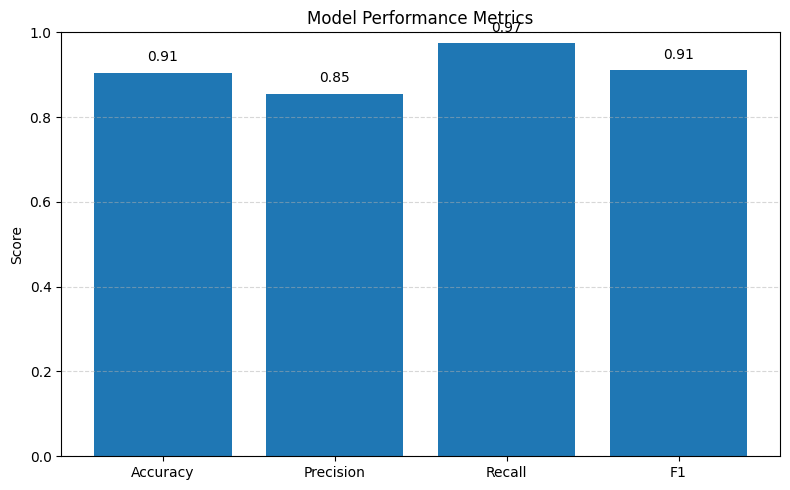

In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ——————————————————————————
# 1. Predictions + Ground Truth
preds     = trainer.predict(test_dataset)
y_true    = preds.label_ids
y_pred    = preds.predictions.argmax(axis=1)

# ——————————————————————————
# 2. Compute Metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=1)  # adjust pos_label as needed
recall    = recall_score(y_true, y_pred, pos_label=1)
f1        = f1_score(y_true, y_pred, pos_label=1)

# ——————————————————————————
# 3. Plotting with matplotlib
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
values  = [accuracy, precision, recall, f1]

plt.figure(figsize=(8,5))
bars = plt.bar(range(len(values)), values)
plt.ylim(0, 1.0)
plt.xticks(range(len(values)), metrics)
plt.title('Model Performance Metrics')
plt.ylabel('Score')

# annotate values above bars
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.2f}',
             ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ——————————————————————————
# 4. (Optional) Export to CSV
results_df = pd.DataFrame({'Metric': metrics, 'Value': values})
results_df.to_csv('performance_metrics.csv', index=False)


Map:   0%|          | 0/4261 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ayush\AppData\Local\Temp\ipykernel_7100\4135069199.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


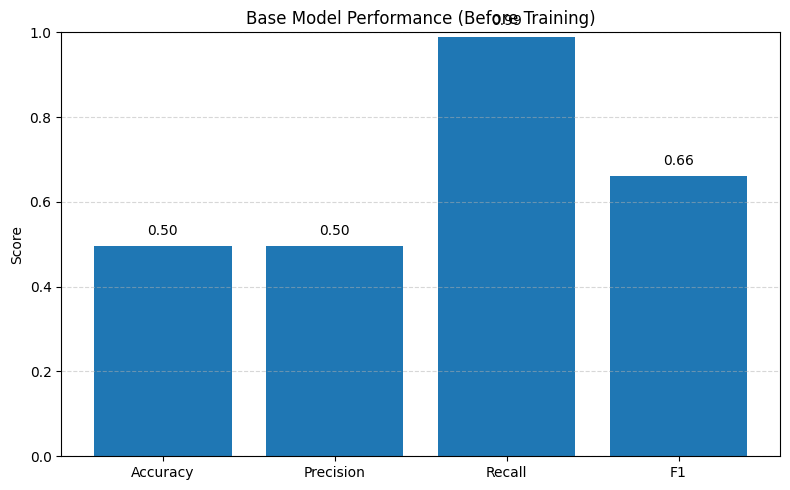

Base model evaluation complete. Results saved to base_model_performance.csv


In [27]:
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Load your test data
# Adjust the path and encoding as needed
test_df = pd.read_csv('IFND.csv', encoding='latin1')
# Make sure label column is named 'labels'
if 'labels' not in test_df.columns and 'Label' in test_df.columns:
    test_df = test_df.rename(columns={'Label': 'labels'})

# 2. Create Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)

# 3. Tokenize the test data
model_name = "bert-base-uncased"  # or "berta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['Statement'], padding=True, truncation=True, max_length=128)

test_dataset = test_dataset.map(tokenize, batched=True)

# 4. Load the base (pretrained, untrained) model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 5. Set up Trainer (no training, just evaluation)
training_args = TrainingArguments(
    output_dir="./base-eval",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=True,
    logging_dir="./base-eval-logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# 6. Run predictions on the test set
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# 7. Compute metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=1)
recall    = recall_score(y_true, y_pred, pos_label=1)
f1        = f1_score(y_true, y_pred, pos_label=1)

# 8. Visualize results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
values  = [accuracy, precision, recall, f1]

plt.figure(figsize=(8,5))
bars = plt.bar(range(len(values)), values)
plt.ylim(0, 1.0)
plt.xticks(range(len(values)), metrics)
plt.title('Base Model Performance (Before Training)')
plt.ylabel('Score')

# annotate values above bars
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.2f}',
             ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 9. (Optional) Export to CSV
results_df = pd.DataFrame({'Metric': metrics, 'Value': values})
results_df.to_csv('base_model_performance.csv', index=False)

print("Base model evaluation complete. Results saved to base_model_performance.csv")
